# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 9?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC
import sklearn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import KFold

In [108]:
svm = SVC(kernel='linear')
params_svc = {
    'C': [1e-3, 1e-2, 1e-1, 1, 3, 4, 5, 6, 10, 20],
}

grid_svc = GridSearchCV(estimator=svm, param_grid=params_svc, scoring='average_precision', verbose = 0, cv = 5)
grid_result_svc = grid_svc.fit(X_train,y_train)

In [109]:
print("Best params: ", (grid_result_svc.best_params_))

Best params:  {'C': 0.001}


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

AUC-PR = 0.82169
ROC-AUC = 0.84726


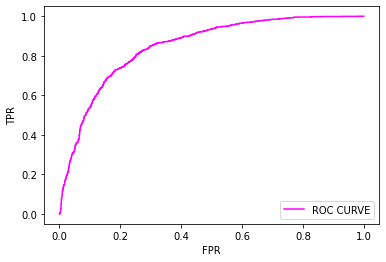

In [110]:
svm = SVC(kernel='linear', C=0.001)
svm.fit(X_train, y_train)
y_pred = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, np.around(y_pred, 5))
plt.plot(fpr, tpr, color='magenta', label='ROC CURVE')
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
print('AUC-PR = %0.5f' % average_precision_score(y_test, y_pred))
print('ROC-AUC = %0.5f' % roc_auc_score(y_test, y_pred))

AUC-PR = 0.82169
ROC-AUC = 0.84726


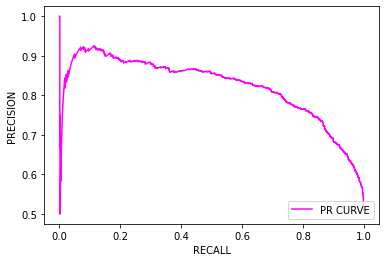

In [111]:
y_pred = svm.decision_function(X_test)
pr, rec, thresholds = precision_recall_curve(y_test, np.around(y_pred, 5))
plt.plot(rec, pr, color='magenta', label='PR CURVE' % auc(rec, pr))
plt.legend(loc='lower right')
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
print('AUC-PR = %0.5f' % average_precision_score(y_test, y_pred))
print('ROC-AUC = %0.5f' % roc_auc_score(y_test, y_pred))

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [112]:
logreg = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                          tol=1e-5, penalty='l2', solver='liblinear')
params_logreg = {
    'C': [1e-3, 1e-2, 1e-1, 1, 3, 4, 5, 6, 10, 20],
    
}

grid_logreg = GridSearchCV(estimator=logreg, param_grid=params_logreg, scoring='roc_auc', verbose = 0, cv = 5)
grid_result_logreg = grid_logreg.fit(X_train,y_train)


In [113]:
print("Best params: ", (grid_result_logreg.best_params_))

Best params:  {'C': 3}


AUC-PR = 0.82937
ROC-AUC = 0.84787


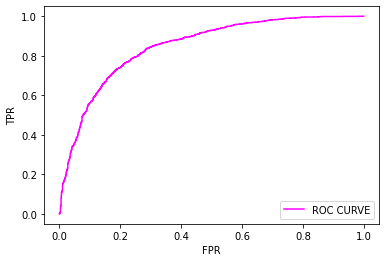

In [114]:
logreg = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                          tol=1e-5, penalty='l2', solver='liblinear', C=3)
logreg.fit(X_train, y_train)
y_pred = logreg.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, np.around(y_pred, 5))
plt.plot(fpr, tpr, color='magenta', label='ROC CURVE')
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
print('AUC-PR = %0.5f' % average_precision_score(y_test, y_pred))
print('ROC-AUC = %0.5f' % roc_auc_score(y_test, y_pred))

AUC-PR = 0.82937
ROC-AUC = 0.84787


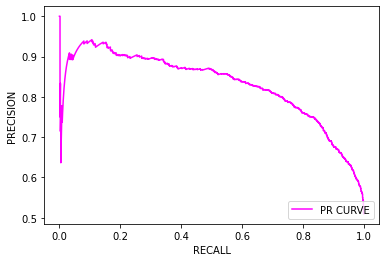

In [115]:
logreg = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                          tol=1e-5, penalty='l2', solver='liblinear', C=3)
logreg.fit(X_train, y_train)
y_pred = logreg.decision_function(X_test)
pr, rec, thresholds = precision_recall_curve(y_test, np.around(y_pred, 5))
plt.plot(rec, pr, color='magenta', label='PR CURVE' % auc(rec, pr))
plt.legend(loc='lower right')
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
print('AUC-PR = %0.5f' % average_precision_score(y_test, y_pred))
print('ROC-AUC = %0.5f' % roc_auc_score(y_test, y_pred))

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

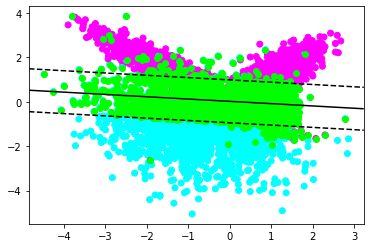

In [56]:
X, y = make_classification(n_samples=10000, n_features=2, 
                          n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

svm = SVC(kernel='linear', C=0.001)
svm.fit(X_train, y_train)
y_pred_train = svm.decision_function(X_train)

ax = plt.gca()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='cool' )
X, y = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1]),
                     np.linspace(ax.get_ylim()[0], ax.get_ylim()[1]))
Z = svm.decision_function(np.c_[X.ravel(), y.ravel()])
plt.contour(X, y, Z.reshape(X.shape), colors='black', levels=[-1, 0, 1],
            linestyles=['--', '-', '--'])


support_vectors = X_train[np.where((2 * y_train - 1) * y_pred_train <= 1)[0]]
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
           facecolors='lime')



__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [113]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        bin_real_ratios.append(np.sum((preds >= l) & (preds < r) & (y_test == 1)) / (np.sum((preds >= l) & (preds < r)))) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, color='magenta')
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

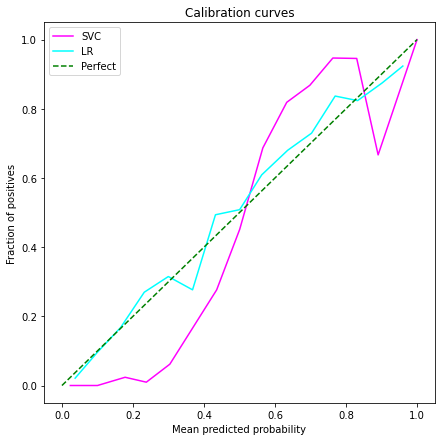

In [34]:
plt.figure(figsize=(7, 7))
X, y = make_classification( n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
answers_svm = svm.decision_function(X_test)

logreg = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                          tol=1e-5, penalty='l2', solver='liblinear', C=3).fit(X_train, y_train)

answers_svm = (answers_svm - answers_svm.min()) / (answers_svm.max() - answers_svm.min())
answers_logreg = logreg.predict_proba(X_test)[:, 1]

svc_true_prob, svc_pred_prob = calibration_curve(y_test, answers_svm, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, answers_logreg, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='magenta')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='cyan')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

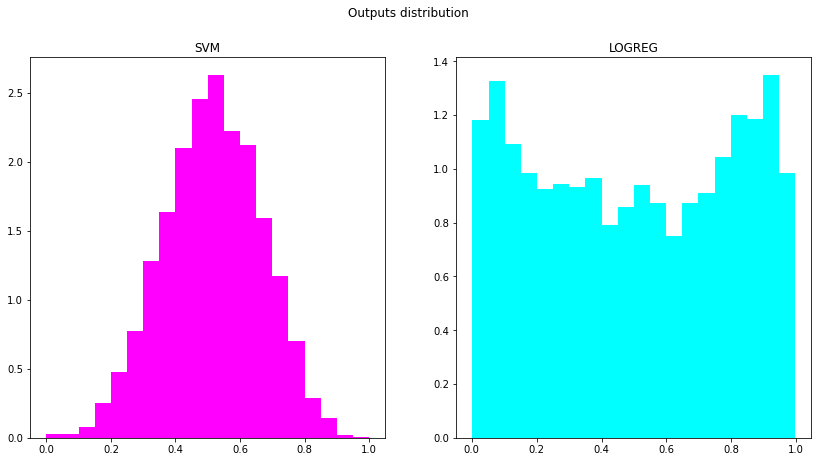

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(answers_svm, bins=20, color='magenta', density='True')
axs[1].hist(answers_logreg, bins=20, color='cyan', density='True')

axs[0].set_title('SVM')
axs[1].set_title('LOGREG')

plt.suptitle('Outputs distribution')
plt.show()

**Вывод:**  логистическая регрессия слишком "уверена" в предсказаниях (из-за быстрого приближения сигмоиды к асимптотам), а svm, напротив, "не уверен" в большинстве объектов (действительно, как мы видели, многие из низ оказываются внутри разделяющей полосы)


Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

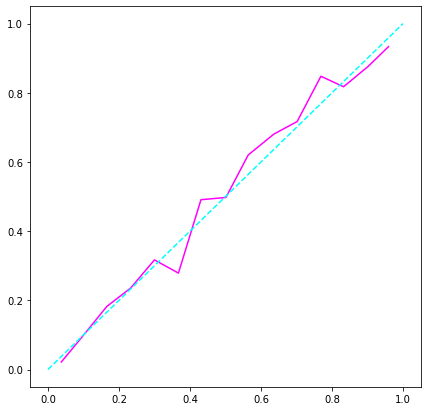

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
svm = CalibratedClassifierCV(LinearSVC(max_iter=1000, C=0.1)).fit(X_train, y_train)
answers_svm = svm.predict_proba(X_test)[:,1]
svc_true_prob, svc_pred_prob = calibration_curve(y_test, answers_svm, n_bins=15)
axs.plot(svc_pred_prob, svc_true_prob, label='SVC', color='magenta')
axs.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='cyan')
plt.show()

**Вывод:** Улучшилась

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [117]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [118]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [119]:
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [120]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)


Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: рок аук сломается из-за диспаланса классов. Потому что нулевого класса оч много и даже предсказав всем нули был бы хороший алгоритм с точки зрения рок аук

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [122]:
columns_to_code = ['marital', 'job', 'education', 'poutcome','default', 
                   'housing', 'loan', 'contact', 'month', 'day_of_week']

In [123]:
columns_to_scale = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [124]:
start = time.time()
ore = OrdinalEncoder()

x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
y = x_test[columns_to_scale].reset_index().drop('index', axis=1)

ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]))
ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]))

x_train = x.join(ore_train)
x_test = y.join(ore_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))


TIME =  32.65709471702576
AUC-PR = 0.4356532841059827


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [125]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [126]:
start = time.time()
ore = OneHotEncoder()

x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
y = x_test[columns_to_scale].reset_index().drop('index', axis=1)

ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

x_train = x.join(ore_train)
x_test = y.join(ore_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))



TIME =  105.15810894966125
AUC-PR = 0.4456223644107429


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

**Ответ**:  качество предсказаний немного ухудшилось, но при этом работает в 3 раза быстрее


In [66]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [67]:
start = time.time()
categories = dict()
for category in columns_to_code:
    val_dict = dict()
    for name in  pd.unique(x_train[category]):
        new_val = ((x_train[category] == name) & (y_train == 1)).sum() / ((x_train[category] == name).sum() + 1)
        val_dict[name] = new_val
    categories[category] = val_dict

for category in columns_to_code:
    x_train[category] = x_train[category].apply(lambda x: categories[category].get(x, 0))
    x_test[category] = x_test[category].apply(lambda x: categories[category].get(x, 0))

    
sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  35.94538187980652
AUC-PR = 0.42532393512740757


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [68]:
sgdr_x_pred = sgdr.predict_proba(x_train)[:, 1]
print('AUC-PR =', average_precision_score(y_train, sgdr_x_pred))

AUC-PR = 0.4183700133019832


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

In [70]:
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise=1e-3):
        self.columns_to_code = columns_to_code
        self.noise = noise
        
    def fit(self, x, y):
        self.categories = dict()
        for category in self.columns_to_code:
            val_dict = dict()
            for name in  pd.unique(x[category]):
                new_val = ((x[category] == name) & (y == 1)).sum() / ((x[category] == name).sum())
                val_dict[name] = new_val + np.random.randn() * self.noise
            self.categories[category] = val_dict
        return self
        
    def transform(self, x):
        for category in self.columns_to_code:
            x[category] = x[category].apply(lambda x: self.categories[category].get(x, 0))
        return x
        

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

**Ответ**:



__(0.5 балла)__

In [71]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [72]:
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise):
        self.columns_to_code = columns_to_code
        self.noise = noise
        
    def fit(self, x, y):
        self.categories = dict()
        for category in self.columns_to_code:
            val_dict = dict()
            for name in  pd.unique(x[category]):
                new_val = ((x[category] == name) & (y == 1)).sum() / ((x[category] == name).sum() + 1)
                val_dict[name] = new_val + np.random.randn() * self.noise
            self.categories[category] = val_dict
        return self
        
    def transform(self, x):
        for category in self.columns_to_code:
            x[category] = x[category].apply(lambda x: self.categories[category].get(x, 0))
        return x
        

In [73]:
cntr = MyEncoder(columns_to_code, 0.5)

In [74]:
start = time.time()
cntr.fit(x_train, y_train)
x_train = cntr.transform(x_train)
x_test = cntr.transform(x_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  36.866886138916016
AUC-PR = 0.42639610749831924


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [75]:
sgdr_x_pred = sgdr.predict_proba(x_train)[:, 1]
print('AUC-PR =', average_precision_score(y_train, sgdr_x_pred))

AUC-PR = 0.4236316978819998


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [139]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [76]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [77]:
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise, smoth):
        self.columns_to_code = columns_to_code
        self.noise = noise
        self.smoth = smoth
        
    def fit(self, x, y):
        self.categories = dict()
        for category in self.columns_to_code:
            val_dict = dict()
            for name in  pd.unique(x[category]):
                new_val = (((x[category] == name) & (y == 1)).sum() + self.smoth * np.mean(y)) / \
                ((x[category] == name).sum() + 1 + self.smoth)
                val_dict[name] = new_val + np.random.randn() * self.noise
            self.categories[category] = val_dict
        return self
        
    def transform(self, x):
        for category in self.columns_to_code:
            x[category] = x[category].apply(lambda x: self.categories[category].get(x, 0))
        return x

In [78]:
cntr = MyEncoder(columns_to_code, 0.5, 10)

start = time.time()
cntr.fit(x_train, y_train)
x_train = cntr.transform(x_train)
x_test = cntr.transform(x_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  34.00833296775818
AUC-PR = 0.4326335936405939


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [79]:
sgdr_x_pred = sgdr.predict_proba(x_train)[:, 1]
print('AUC-PR =', average_precision_score(y_train, sgdr_x_pred))

AUC-PR = 0.425921976808806


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [80]:
df.age.unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

In [81]:
len(df.age.unique())

78

In [82]:
columns_to_code.append('age')

In [83]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [84]:
cntr = MyEncoder(columns_to_code, 0.5, 10)

start = time.time()
cntr.fit(x_train, y_train)
x_train = cntr.transform(x_train)
x_test = cntr.transform(x_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  33.21409773826599
AUC-PR = 0.43355662138176165


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [85]:
sgdr_x_pred = sgdr.predict_proba(x_train)[:, 1]
print('AUC-PR =', average_precision_score(y_train, sgdr_x_pred))

AUC-PR = 0.4300842365773292


**Ответ**: стало хуже

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [86]:
columns_to_code.remove('age')

In [90]:
import calendar

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)

m = {month.lower(): index - 1 for index, month in enumerate(calendar.month_abbr) if month}
w = dict(zip(calendar.weekheader(3).lower().split(' '), range(7)))
n = df.copy()
for month in pd.unique(df['month']):
    df.loc[df['month'] == month, 'month'] = m[month]

for wday in pd.unique(df['day_of_week']):
    df.loc[df['day_of_week'] == wday, 'day_of_week'] = w[wday]

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['duration', 'y']), 
                                                    df['y'], test_size=0.25, random_state=777, stratify=df.y)

In [91]:
cntr = MyEncoder(columns_to_code, 0.5, 10)

start = time.time()
cntr.fit(x_train, y_train)
x_train = cntr.transform(x_train)
x_test = cntr.transform(x_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  34.72768211364746
AUC-PR = 0.4276137047938115


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [92]:
sgdr_x_pred = sgdr.predict_proba(x_train)[:, 1]
print('AUC-PR =', average_precision_score(y_train, sgdr_x_pred))

AUC-PR = 0.4261603341966863


**Ответ**:да, стало

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
Плюсы: 
1) несут в себе больше информации о значениях таргета

2) не увеличивают количество признаков

Минусы:

1) возможно переобучение


# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [154]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [155]:
start = time.time()
ore = OneHotEncoder()

x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
y = x_test[columns_to_scale].reset_index().drop('index', axis=1)

ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

x_train = x.join(ore_train)
x_test = y.join(ore_test)

sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  103.78445434570312
AUC-PR = 0.44415382560002703


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [156]:
x_train.shape

(32950, 62)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [157]:
test_score = average_precision_score(y_test, sgdr_y_pred)
print(test_score)

0.44415382560002703


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

109 секунд + ячейки 158-160(мнгновенно)

Изменилось ли качество? Как?



In [158]:
best_features = np.abs(sgdr.coef_[0]).argsort()[-40:]

In [159]:
len(np.unique(best_features))

40

In [160]:
x_train_bf = x_train.iloc[:, best_features]
x_test_bf = x_test.iloc[:, best_features]

In [161]:
start = time.time()

best_features = np.abs(sgdr.coef_[0]).argsort()[-40:]


sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train_bf, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test_bf)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  69.47633814811707
AUC-PR = 0.44688631434749176


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [162]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [5]:
columns_to_scale = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
columns_to_code = ['marital', 'job', 'education', 'poutcome','default', 
                   'housing', 'loan', 'contact', 'month', 'day_of_week']

In [164]:
stsc = StandardScaler()
ohe = OneHotEncoder()


StandardScal1 = pd.DataFrame(stsc.fit_transform(x_train[columns_to_scale]))
StandardScal1.columns = columns_to_scale

StandardScal2 = pd.DataFrame(stsc.transform(x_test[columns_to_scale]))
StandardScal2.columns = columns_to_scale

ohe_h = pd.DataFrame(ohe.fit_transform(x_train[columns_to_code]).toarray())
ohe_test = pd.DataFrame(ohe.transform(x_test[columns_to_code]).toarray())

x_train = StandardScal1.join(ohe_h)
x_test = StandardScal2.join(ohe_test)


sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


best_features = np.abs(sgdr.coef_[0]).argsort()[-40:]
x_train_bf = x_train.iloc[:, best_features]
x_test_bf = x_test.iloc[:, best_features]


best_features = np.abs(sgdr.coef_[0]).argsort()[-40:]


sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train_bf, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test_bf)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


TIME =  241.0103099346161
AUC-PR = 0.44405606827384775


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [165]:
best_features.sort()
best_features

array([ 2,  4,  5,  7,  8,  9, 10, 11, 14, 16, 18, 23, 25, 27, 28, 29, 30,
       33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 57, 58])

Качество незначительно ухудшилось, по факту не изменилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [166]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [167]:
stsc = StandardScaler()
ohe = OneHotEncoder()


ohe_h = pd.DataFrame(ohe.fit_transform(x_train[columns_to_code]).toarray())
ohe_test = pd.DataFrame(ohe.transform(x_test[columns_to_code]).toarray())

x_train = x_train[columns_to_scale].reset_index().drop('index', axis=1)
x_test = x_test[columns_to_scale].reset_index().drop('index', axis=1)

x_train = x_train.join(ohe_h)
x_test = x_test.join(ohe_test)

StandardScal1 = pd.DataFrame(stsc.fit_transform(x_train))
StandardScal2 = pd.DataFrame(stsc.transform(x_test))


x_train = StandardScal1
x_test = StandardScal2


sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train, y_train)


best_features1 = np.abs(sgdr.coef_[0]).argsort()[-40:]
x_train_bf = x_train.iloc[:, best_features]
x_test_bf = x_test.iloc[:, best_features]


best_features1 = np.abs(sgdr.coef_[0]).argsort()[-40:]


sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train_bf, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test_bf)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))

TIME =  265.39708614349365
AUC-PR = 0.4440904029935622


In [168]:
best_features1.sort()
best_features1

array([ 1,  2,  3,  4,  5,  6,  7,  8, 13, 14, 18, 20, 21, 22, 25, 26, 31,
       33, 34, 35, 36, 37, 38, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 58, 59, 60, 61])

In [169]:
set(best_features1).symmetric_difference(set(best_features))

{1,
 3,
 6,
 9,
 10,
 11,
 13,
 16,
 20,
 21,
 22,
 23,
 26,
 27,
 28,
 29,
 30,
 31,
 35,
 39,
 40,
 41,
 43,
 44,
 45,
 56,
 57,
 59,
 60,
 61}

**Изменился ли их список? Изменится ли качество?**: изменился список, качество улучшилось вообще незначительно(не изменилось)

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [265]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [266]:
ore = OneHotEncoder()

x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
y = x_test[columns_to_scale].reset_index().drop('index', axis=1)

ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

y_train = y_train.reset_index().drop('index', axis=1)
x_train = x.join(ore_train)
x_test = y.join(ore_test)

In [268]:
start = time.time()
t_stat = dict()
columns = x_train.columns
for col in columns:
    column = x_train[col]
    
    positive = column[(y_train == 1).y]
    negative = column[(y_train == 0).y]

    nominator = np.abs(positive.mean() - negative.mean())

    denominator = positive.shape[0] * np.var(positive ,axis=0) 
    denominator += negative.shape[0] * np.var(negative ,axis=0)
    denominator = denominator / X.shape[0]
    denominator = np.sqrt(denominator)

    t = nominator / denominator

    t_stat[col] = t


best_features_stat = sorted(t_stat, key=t_stat.get)[-40:]
x_train_bf = x_train[best_features_stat]
x_test_bf = x_test[best_features_stat]



sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
sgdr.fit(x_train_bf, y_train)
sgdr_y_pred = sgdr.predict_proba(x_test_bf)[:, 1]

print('TIME = ', time.time() - start)
print('AUC-PR =', average_precision_score(y_test, sgdr_y_pred))


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TIME =  69.28559517860413
AUC-PR = 0.4441739844450241


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.



In [19]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

folds = KFold(n_splits=5, random_state=500, shuffle=True)
vir = []
prof = []
loss = []
for train_idx, test_idx in folds.split(X):
    x_train, x_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    ore = OneHotEncoder()

    x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
    yy = x_test[columns_to_scale].reset_index().drop('index', axis=1)

    ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
    ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

    y_train = y_train.reset_index().drop('index', axis=1)
    x_train = x.join(ore_train)
    x_test = yy.join(ore_test)
    
    sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
    sgdr.fit(x_train, y_train)
    sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

    loss.append(sgdr_y_pred.sum())
    vir.append((sgdr_y_pred * y_test).sum() * 10)
    prof.append(vir[-1] - loss[-1])


/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max

In [20]:
print('MEAN VIRUCHKA: ', np.mean(vir))
print('MEAN PROFIT: ', np.mean(prof))
print('ST DEVIATION PROFIT: ', np.std(np.array(prof)))

MEAN VIRUCHKA:  2692.2235480310264
MEAN PROFIT:  1764.2121547846223
ST DEVIATION PROFIT:  50.12613678504998


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [28]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

folds = KFold(n_splits=5, random_state=500, shuffle=True)
vir = []
prof = []
loss = []
for train_idx, test_idx in folds.split(X):
    x_train, x_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    ore = OneHotEncoder()

    x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
    yy = x_test[columns_to_scale].reset_index().drop('index', axis=1)

    ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
    ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

    y_train = y_train.reset_index().drop('index', axis=1)
    x_train = x.join(ore_train)
    x_test = yy.join(ore_test)
    
    sgdr = LogisticRegression(fit_intercept = True, max_iter = 10000, 
                          tol=1e-5, penalty='none', solver='sag')
    sgdr.fit(x_train, y_train)
    sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

    loss.append(sgdr_y_pred.sum())
    vir.append((sgdr_y_pred * y_test).sum() * np.random.rand() * 20)
    prof.append(vir[-1] - loss[-1])

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max

In [29]:
print('MEAN VIRUCHKA: ', np.mean(vir))
print('MEAN PROFIT: ', np.mean(prof))
print('ST DEVIATION PROFIT: ', np.std(np.array(prof)))

MEAN VIRUCHKA:  2694.406075869615
MEAN PROFIT:  1766.395611259078
ST DEVIATION PROFIT:  2065.602372326665


**Что получилось**: видим, что средние значения от этого не изменилась, при этом дисперсия возможного profit-а значительно увеличиась, что естественно т.к. предсказания теперь случайны

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [51]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
space = np.linspace(0.01, 10, 10)
profits = []
stds = []

best_profit = 0
best_c = -1

for c in space:
    folds = KFold(n_splits=5, random_state=500, shuffle=True)
    vir = []
    prof = []
    loss = []
    for train_idx, test_idx in folds.split(X):
        x_train, x_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        ore = OneHotEncoder()

        x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
        yy = x_test[columns_to_scale].reset_index().drop('index', axis=1)

        ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
        ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

        y_train = y_train.reset_index().drop('index', axis=1)
        x_train = x.join(ore_train)
        x_test = yy.join(ore_test)

        sgdr = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                              tol=1e-5, C=c)
        sgdr.fit(x_train, y_train)
        sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

        loss.append(sgdr_y_pred.sum())
        vir.append((sgdr_y_pred * y_test).sum() * np.random.rand() * 20)
        prof.append(vir[-1] - loss[-1])
    
    
    profit = np.mean(prof)
    profits.append(profit)
    stds.append(np.std(prof))
    if profit > best_profit:
        best_profit = profit
        best_c = c
    
    
print('BEST C: ', best_c)
print('BEST PROFIT: ', best_profit)

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

BEST C:  4.45
BEST PROFIT:  3320.050475004437


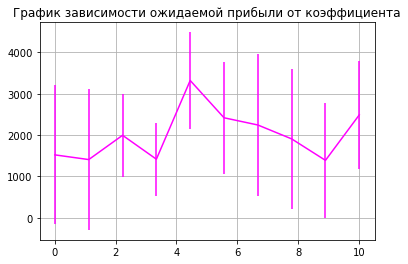

In [53]:
plt.errorbar(space, profits, stds, color='magenta')
plt.title('График зависимости ожидаемой прибыли от коэффициента')
plt.grid()


**ответ**: увеличилась в 2 раза средняя выручка
    

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

**ответ**: Сделаю два раза одно и то же. 

In [54]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
space = np.linspace(0.01, 10, 10)
profits = []
stds = []

best_profit = 0
best_c = -1

for c in space:
    folds = KFold(n_splits=5, random_state=500, shuffle=True)
    vir = []
    prof = []
    loss = []
    for train_idx, test_idx in folds.split(X):
        x_train, x_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        ore = OneHotEncoder()

        x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
        yy = x_test[columns_to_scale].reset_index().drop('index', axis=1)

        ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
        ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

        y_train = y_train.reset_index().drop('index', axis=1)
        x_train = x.join(ore_train)
        x_test = yy.join(ore_test)

        sgdr = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                              tol=1e-5, C=c)
        sgdr.fit(x_train, y_train)
        sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

        loss.append(sgdr_y_pred.sum())
        vir.append((sgdr_y_pred * y_test).sum() * np.random.rand() * 20)
        prof.append(vir[-1] - loss[-1])
    
    
    profit = np.mean(prof)
    profits.append(profit)
    stds.append(np.std(prof))
    if profit > best_profit:
        best_profit = profit
        best_c = c
    
    
print('BEST C: ', best_c)
print('BEST PROFIT: ', best_profit)

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

BEST C:  1.12
BEST PROFIT:  2621.8294812855547


In [55]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
space = np.linspace(0.01, 10, 10)
profits = []
stds = []

best_profit = 0
best_c = -1

for c in space:
    folds = KFold(n_splits=5, random_state=500, shuffle=True)
    vir = []
    prof = []
    loss = []
    for train_idx, test_idx in folds.split(X):
        x_train, x_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        ore = OneHotEncoder()

        x = x_train[columns_to_scale].reset_index().drop('index', axis=1)
        yy = x_test[columns_to_scale].reset_index().drop('index', axis=1)

        ore_train = pd.DataFrame(ore.fit_transform(x_train[columns_to_code]).toarray())
        ore_test = pd.DataFrame(ore.transform(x_test[columns_to_code]).toarray())

        y_train = y_train.reset_index().drop('index', axis=1)
        x_train = x.join(ore_train)
        x_test = yy.join(ore_test)

        sgdr = LogisticRegression(fit_intercept = True, max_iter = 1000, 
                              tol=1e-5, C=c)
        sgdr.fit(x_train, y_train)
        sgdr_y_pred = sgdr.predict_proba(x_test)[:, 1]

        loss.append(sgdr_y_pred.sum())
        vir.append((sgdr_y_pred * y_test).sum() * np.random.rand() * 20)
        prof.append(vir[-1] - loss[-1])
    
    
    profit = np.mean(prof)
    profits.append(profit)
    stds.append(np.std(prof))
    if profit > best_profit:
        best_profit = profit
        best_c = c
    
    
print('BEST C: ', best_c)
print('BEST PROFIT: ', best_profit)

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

BEST C:  7.78
BEST PROFIT:  3209.1934155480617


**Вывод**

BEST C:  4.45
BEST PROFIT:  3320.050475004437
    
BEST C:  1.12
BEST PROFIT:  2621.8294812855547

BEST C:  7.78
BEST PROFIT:  3209.1934155480617

Подбираются разные тк для разного С профит случайный


__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ боль

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ про машинку..........

![](123.jpeg)